In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow as gp
import numpy as np
import pylab as plt

def wrap(phi):
    return tf.atan2(tf.sin(phi),tf.cos(phi))

def likelihood(tec, l, times, phase, tec_conversion, lik_sigma, K = 2):
    """
    Get the likelihood of the tec given phase data and lik_var variance.
    tec: tensor B
    l: tensor scalar
    times: tensor B
    phase: tensor B, Nf
    tec_conversion: tensor Nf
    lik_sigma: tensor B
    Returns:
    log_prob: tensor 1
    
    log[ int dtec p(phase | tec) + p(tec | l)]
    log[ N()]
    """
    mu = wrap(tec[:,None]*tec_conversion[None,:])# B, Nf
    phase = wrap(phase)# B, Nf
    #K, B, Nf
    d = tf.stack([tf.distributions.Normal(mu + tf.convert_to_tensor(k*2*np.pi,tf.float32), 
                                          lik_sigma).log_prob(phase) for k in range(-K,K+1,1)], axis=0)
    d = tf.stack([tfp.distributions.MultivariateNormalDiag(
        mu + tf.convert_to_tensor(k*2*np.pi,tf.float32),scale_diag=lik_sigma).log_prob(phase) for k in range(-K,K+1,1)], axis=0)
    
    #B, Nf -> B
    log_lik = tf.reduce_logsumexp(d, axis=0)
    
    
    # B, 1
    times = times/l
    dx = times - tf.transpose(times)
    dx2 = tf.square(dx)
    cov = tf.exp(-dx2)  + 1e-6*tf.eye(tf.shape(times)[0])
    var = tf.reduce_mean((tec - tf.reduce_mean(tec)))
    tec = tec/0.1
    tec_prior = tfp.distributions.MultivariateNormalFullCovariance(tf.zeros(tf.shape(tec))[None,:],cov[None,:,:]).log_prob(tec[None,:])
    
    l_prior = tfp.distributions.Normal(50.,1.).log_prob(l)
    #B, 1
    log_prob =  log_lik + tec_prior + l_prior
       
    return tec_prior


    

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)


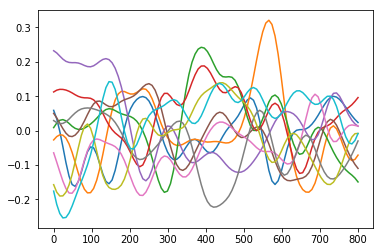

ValueError: operands could not be broadcast together with shapes (100,10) (1,25) 

In [32]:
l = 40.
with tf.Session(graph=tf.Graph()) as sess:
    time = np.linspace(0.,100*8.,100)[:,None]
    kern = gp.kernels.RBF(1,variance=1.,lengthscales=l)
    kern.compile()
    cov = kern.compute_K_symm(time)
    cov = cov
    L = 0.1*np.linalg.cholesky(cov + 1e-6*np.eye(cov.shape[0]))
    z = np.random.normal(size=[time.shape[0],10])
    tec = L.dot(z)
        
    plt.plot(time[:,0],tec)
    plt.show()
    freqs = np.linspace(120e6, 160e6,25)
    tec_conversion = -8.448e9/freqs
    true_phase = tec*tec_conversion[None,:]
    phase = true_phase + 0.3*np.random.normal(size=true_phase.shape)

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)


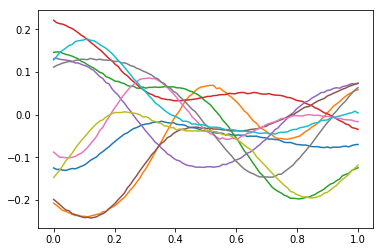

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use float_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/logdensities.py:91: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('Shape of x must be 2D at computation.')


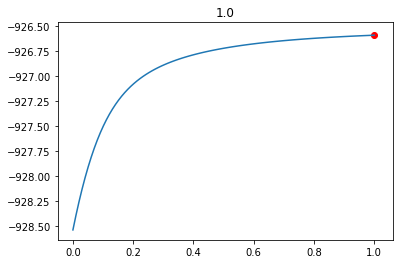

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)


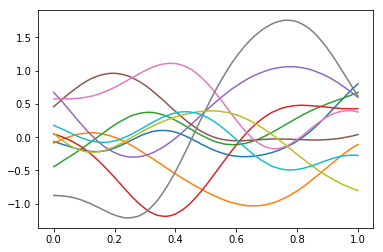

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use float_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/logdensities.py:91: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('Shape of x must be 2D at computation.')


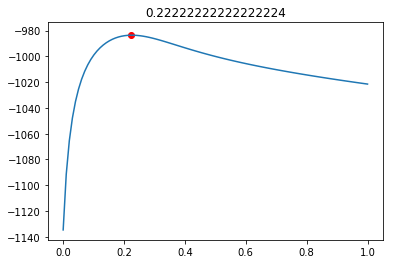

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)


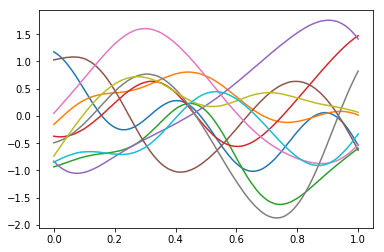

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use float_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/logdensities.py:91: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('Shape of x must be 2D at computation.')


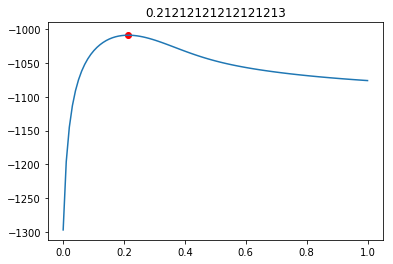

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)


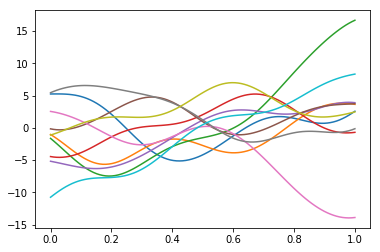

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use float_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/logdensities.py:91: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('Shape of x must be 2D at computation.')


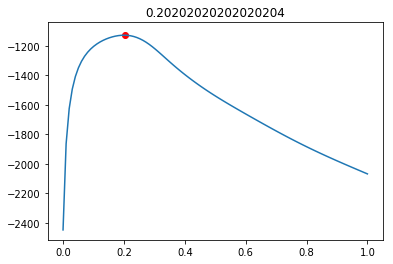

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)


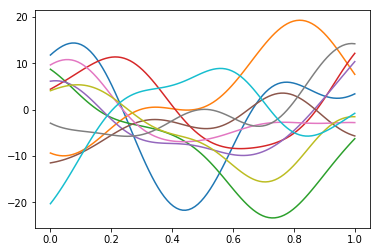

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:61: DeprecationWarning: tf_float is deprecated and will be removed at GPflow version 1.2.0. Use float_type.
  'version 1.2.0. Use float_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/logdensities.py:91: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('Shape of x must be 2D at computation.')


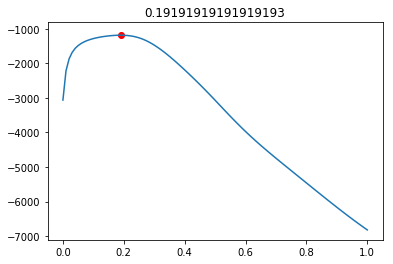

In [62]:


def get_min_l(l=0.5,sigma=1.):
    with tf.Session(graph=tf.Graph()) as sess:
        X = np.linspace(0.,1.,100)[:,None]
        kern = gp.kernels.RBF(1,variance=sigma**2,lengthscales=l)
        cov = kern.compute_K_symm(X)
        cov = cov
        L = scale*np.linalg.cholesky(cov + 1e-6*np.eye(cov.shape[0]))
        z = np.random.normal(size=[time.shape[0],10])
        Y = L.dot(z)

        plt.plot(X[:,0],Y)
        plt.show()
        
        with gp.defer_build():
            model = gp.models.GPR(X,Y,kern)
            model.likelihood.variance=0.001**2
            model.likelihood.trainable = False
            model.compile()
        

        data_term = []
        l_array = np.linspace(0.01,1,100)
        for l in l_array:
            model.kern.lengthscales = l
            
            data_term.append(model.compute_log_likelihood())
        plt.plot(l_array, data_term)
        am = np.argmax(data_term)
        plt.scatter(l_array[am], data_term[am],c='red')
        plt.title(l_array[am])
        plt.show()
        return l_array[am]
        
test(l=.2,sigma=0.1)
test(l=.2,sigma=0.5)
test(l=.2,sigma=1.)
test(l=.2,sigma=5.)
test(l=.2,sigma=10.)
        

In [5]:
with tf.Session(graph=tf.Graph()) as sess:
    tec_pl = tf.placeholder(tf.float32)
    l_pl = tf.placeholder(tf.float32)
    phase_pl = tf.placeholder(tf.float32)
    times_pl = tf.placeholder(tf.float32, shape=time.shape)
    tec_conversion_pl = tf.placeholder(tf.float32)
    
    lik_ = likelihood(tec_pl, l_pl, times_pl, phase_pl, tec_conversion_pl, tf.constant([0.3]), K = 4)
    
    tec_array = np.linspace(-0.1,0.1,100)
    l_array = np.linspace(8,100,100)
    res = []
    for l in l_array:
        
        lik = sess.run(lik_,feed_dict={tec_pl:tec[:,0]+0.0011*np.random.normal(size=tec[:,0].shape), 
                                l_pl:l, 
                                times_pl:time, 
                                phase_pl:phase, 
                                tec_conversion_pl:tec_conversion})
        res.append(lik)
        

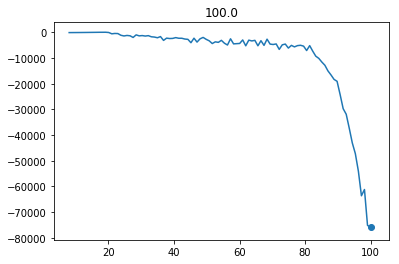

In [6]:
plt.plot(l_array, res)
a =np.argmin(res)
plt.scatter(l_array[a],res[a])
plt.title(l_array[a])
# plt.yscale('log')
plt.show()

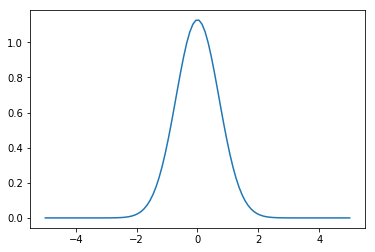

In [9]:
with tf.Session(graph=tf.Graph()) as sess:
    x = tf.constant(np.linspace(-5,5,100))
    f = tf.erf(x)
    g = tf.gradients(f,x)
    plt.plot(np.linspace(-5,5,100), sess.run(g)[0])
    plt.show()
    

## We will create a dense and sparse model and then simulate a known correlation TEC and compare the likelihoods.

In [4]:
from bayes_tec.solvers.phase_only_solver import PhaseOnlySolver
from bayes_tec.datapack import DataPack
import tensorflow as tf
import numpy as np
from tensorflow_probability import math

datapack = '../../scripts/data/killms_datapack_3.hdf5'
datapack = DataPack(datapack)
solver = PhaseOnlySolver('run_dir_prior_test', datapack)

kwargs = {'ant_sel':slice(50,52,1),
          'time_sel':slice(0,20,1),
          'pol_sel':slice(0,1,1), 
          'reweight_obs':False, 
          'dof_ratio':1,
          'coord_file':"coords.hdf5",
          'minibatch_size':128, 
          'tec_scale':0.005,
         "priors":{"kern_time_ls":8.,"kern_dir_ls":0.001}}

solver.output_solset = 'posterior_sol'
solver.output_screen_solset = 'screen_sol'
data_shape, build_params = solver._prepare_data(datapack,**kwargs)



with tf.Session(graph=tf.Graph()) as sess:
    _, data_tensors = solver._train_dataset_iterator(data_shape, sess=sess,**kwargs)
    model = solver._build_model(*data_tensors, **build_params, **kwargs)
    lik_1 = [model.compute_log_likelihood() for i in range(10)]
    
    

2018-09-27 17:18:59,751 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-09-27 17:18:59,757 Closing table.
2018-09-27 17:18:59,761 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-09-27 17:18:59,786 Using 900 inducing points to sparsely model 900 data points
2018-09-27 17:18:59,788 Number of latents L=Na=2, number of outputs P=Na*Npol=2
2018-09-27 17:18:59,789 Performing minibatching with 128 sized batches
2018-09-27 17:18:59,791 Kuu: 2x900x900 [12.36 MB]
2018-09-27 17:18:59,792 Kuf: 2x900x128 [1.76 MB]
2018-09-27 17:18:59,794 Kff: 2x128x128 [0.25 MB]
2018-09-27 17:18:59,795 Calculating coordinates for sol000/phase
2018-09-27 17:18:59,811 Calculating data for sol000/phase


/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)


2018-09-27 17:18:59,999 Creating temporary data source file: /net/lofar1/data1/albert/git/bayes_tec/notebooks/devel/run_dir_prior_test/run_010/data_source_21a97465-8bc5-48ab-affb-49063d26f1f8.hdf5
2018-09-27 17:19:00,010 Initializing sparse conditions: q_mu and q_sqrt
2018-09-27 17:19:00,289 Closing table.


/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow v

In [23]:
with datapack:
    datapack.select(ant=slice(50,52,1), time=slice(0,20,1),pol=slice(0,1,1))
    tec, _ = datapack.tec
    phase, axes = datapack.phase
    _, freqs = datapack.get_freqs(axes['freq'])
    
tec_conversion = -8.4480e9/freqs

float_type = tf.float64
from bayes_tec.utils.stat_utils import log_normal_solve
from bayes_tec.likelihoods import WrappedPhaseGaussianEncodedHetero

def wrap(phi):
    return tf.atan2(tf.sin(phi),tf.cos(phi))

def likelihood(tec, phase, tec_conversion, lik_sigma, Nf, n_torus = 4, K = 1):
    """
    Get the likelihood of the tec given phase data and lik_var variance.
    tec: tensor B, 1
    phase: tensor B, Nf
    tec_conversion: tensor Nf
    lik_sigma: tensor B, 1
    Returns:
    log_prob: tensor (B,1)
    """
    mu = wrap(tec*tec_conversion[None,:])# B, Nf
    phase = wrap(phase)
    # for each l in Nf come up with the permutations of k
    
    grids = tf.meshgrid(*[tf.range(-K,K+1,1,dtype=float_type)]*n_torus,indexing='ij')
    d = []
    for grid in range(n_torus):
        
        d.append(tf.distributions.Normal(mu + tf.convert_to_tensor(k*2*np.pi,float_type), 
                                          lik_sigma).log_prob(phase))
        
    #K, B, Nf
    d = tf.stack([tf.distributions.Normal(mu + tf.convert_to_tensor(k*2*np.pi,float_type), 
                                          lik_sigma).log_prob(phase) for k in range(-K,K+1,1)], axis=0)
    
    #B, Nf -> B
    log_lik = tf.reduce_sum(tf.reduce_logsumexp(d, axis=0), axis=1)
    
    
    # B, 1
    tec_prior = tf.distributions.Normal(
        tf.convert_to_tensor(0.,dtype=float_type),
        tf.convert_to_tensor(0.5,dtype=float_type)).log_prob(tec)
    
    sigma_priors = log_normal_solve(0.2,0.1)
    #B, 1
    sigma_prior = tf.distributions.Normal(
        tf.convert_to_tensor(sigma_priors[0],dtype=float_type), 
        tf.convert_to_tensor(sigma_priors[1],dtype=float_type)).log_prob(tf.log(lik_sigma)) - tf.log(lik_sigma)
    
    #B, 1
    log_prob = log_lik[:,None]# + tec_prior + sigma_prior
    
    return -log_prob

with tf.Session(graph=tf.Graph()) as sess:
    tec_pl = tf.placeholder(float_type)
    phase_pl = tf.placeholder(float_type)
    tec_conversion_pl = tf.placeholder(float_type)
    log_sigma_pl = tf.placeholder(float_type)
    log_lik_2 = likelihood(tec_pl,phase_pl,tec_conversion_pl,log_sigma_pl)
    
    likelihood_gp = WrappedPhaseGaussianEncodedHetero(tec_scale=1.,variance=0.3**2)
    likelihood_gp.compile()
    
    freq_pl = tf.placeholder(float_type)
    log_lik_1 = likelihood_gp.logp(tec_pl,phase_pl,None, freq_pl)
    Npol, Nd, Na, Nf, Nt = phase.shape
    
    lik_2 = sess.run([log_lik_2,], feed_dict={tec_pl:tec.reshape((-1,1)), 
                                         phase_pl:phase.transpose((0,1,2,4,3)).reshape((-1,len(freqs))), 
                                         tec_conversion_pl:tec_conversion, 
                                         log_sigma_pl:0.3,
                                         freq_pl : np.tile(freqs[None, None,None,None,:], (Npol, Nd, Na, Nt, 1)).reshape((-1,1))
                                        })
    
    lik_1 = sess.run([log_lik_1,], feed_dict={tec_pl:np.tile(tec[:,:,:,:,None],(1,1,1,1,Nf)).reshape((-1,1)), 
                                         phase_pl:phase.transpose((0,1,2,4,3)).reshape((-1,1)), 
                                         freq_pl : np.tile(freqs[None, None,None,None,:], (Npol, Nd, Na, Nt, 1)).reshape((-1,1))
                                        })
    

2018-09-27 17:43:34,000 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-09-27 17:43:34,094 Closing table.


/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)


In [24]:
print(np.sum(lik_1)/ np.sum(lik_2))

-0.9999999999999974


In [38]:
x=np.meshgrid(*[[-1,0,1]]*20,indexing='ij')

MemoryError: 

In [ ]:
x[0].size

In [ ]:
3**20